In [38]:
# import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tweepy
import json
import tweetnlp
import openai

In [39]:
all_tweets = pd.read_csv("../../Data/Processed/Sprint6 - sample_tweets_survey_answers - Ecem.csv")

In [40]:
# Creating a new DataFrame with the required columns
new_columns = ["text", "Complaint number", "non complaint number", 
               "uncertain number", "Cem", "ecem", "Shinu J", 
               "Akshay", "Erjon"]
survey_edited = pd.DataFrame(columns=new_columns)

# Populate the "text" column with the column names of the complaint statements
text_columns = all_tweets.columns[2::2]  # Selecting every odd-numbered column starting from the 3rd
survey_edited["text"] = text_columns

# Count the number of complaints, non-complaints, and uncertain entries for each text
complaint_counts = []
non_complaint_counts = []
uncertain_counts = []
topics = {name: [] for name in new_columns[4:]}

for text_col in text_columns:
    # Count the occurrences of each type in the corresponding column
    complaint_counts.append((all_tweets[text_col] == "Complaint").sum())
    non_complaint_counts.append((all_tweets[text_col] == "Non-Complaint").sum())
    uncertain_counts.append((all_tweets[text_col] == "Uncertain").sum())

# Iterate over each text column
for text_col in text_columns:
    topic_col = all_tweets.columns[all_tweets.columns.get_loc(text_col) + 1]  # The next column contains the topics
    
    # Reset current_topics for each text column
    current_topics = {reviewer: None for reviewer in topics}
    
    # Iterate over each row in the DataFrame
    for _, row in all_tweets.iterrows():
        reviewer_name = row['What is your name?'].strip().lower()
        for reviewer in topics:
            # Check if the lowercase stripped name matches any reviewer
            if reviewer.lower() == reviewer_name:
                current_topics[reviewer] = row[topic_col]
                break

    # Append the topic for each reviewer
    for reviewer in topics:
        topics[reviewer].append(current_topics[reviewer])

# Now, add the topics to the new DataFrame
for reviewer, topic_list in topics.items():
    survey_edited[reviewer] = topic_list

# Add counts to the new DataFrame
survey_edited["Complaint number"] = complaint_counts
survey_edited["non complaint number"] = non_complaint_counts
survey_edited["uncertain number"] = uncertain_counts

# add the pattern column showing complaint number + non complaint number + uncertain number

survey_edited['pattern'] = survey_edited['Complaint number'].astype(str) + survey_edited['non complaint number'].astype(str) + survey_edited['uncertain number'].astype(str)
survey_edited['pattern'].value_counts()
survey_edited.head(3)

,text,Complaint number,non complaint number,uncertain number,Cem,ecem,Shinu J,Akshay,Erjon,pattern
0,@TLRailUK why don't the doors open at every st...,5,0,0,Doors,Doors,Doors,Door,doors,500
1,@TLRailUK When on phone to @LNER they said as ...,5,0,0,Delays,Delay,Delay,Delay,cancellations,500
2,@LiveCommute @bus131 @tlupdates @TLRailUK @bri...,5,0,0,Train General,Service,Absence of amenities,Customer experience,Experience,500


In [41]:
#Write patterncolumn's values to a list
survey_edited['pattern'].value_counts()

500    51
050    29
410    12
140     9
Name: pattern, dtype: int64

In [42]:
#Create a new column with the name of Survey_Results and write True if the pattern is 500, 410 or 401
survey_edited['Survey_Results'] = np.where(survey_edited['pattern'].isin(['500','410','401']), True, False)
survey_edited['Survey_Results'].value_counts()

True     63
False    38
Name: Survey_Results, dtype: int64

In [43]:
# Print the pattern distribution
print('The number of tweets in which we all agree is a complaint: ', len(survey_edited[survey_edited['pattern'].str.contains('500')]))
print('The number of tweets in which we all agree is not a complaint: ', len(survey_edited[survey_edited['pattern'].str.contains('050')]))
print('The number of tweets in which its 4 votes for a complaint: ', len(survey_edited[survey_edited['pattern'].str.contains('410|401')]))
print('The number of tweets in which its 4 votes for a non complaint: ', len(survey_edited[survey_edited['pattern'].str.contains('140|041')]))
print('The number of tweets where there is no agreement: ', len(survey_edited[survey_edited['pattern'].str.contains('3|2')]))

The number of tweets in which we all agree is a complaint:  51
The number of tweets in which we all agree is not a complaint:  29
The number of tweets in which its 4 votes for a complaint:  12
The number of tweets in which its 4 votes for a non complaint:  9
The number of tweets where there is no agreement:  0


In [33]:
survey_edited.head(1)

,text,Complaint number,non complaint number,uncertain number,Cem,ecem,Shinu J,Akshay,Erjon,pattern,Survey_Results
0,@TLRailUK why don't the doors open at every st...,5,0,0,Doors,Doors,Doors,Door,doors,500,True


In [46]:
import tweetnlp

# Check for sentiment in the all_tweets_edited dataset using the tweetnlp library and save the results in a new column called sentiment
model = tweetnlp.load_model('sentiment')

# Create a new dataframe called transformed_tweets_sentiment as a copy of all_tweets_edited
transformed_tweets_sentiment = survey_edited.copy()

# Create a new column called 'sentiment' based on the sentiment prediction for each tweet
transformed_tweets_sentiment['sentiment'] = transformed_tweets_sentiment['text'].apply(lambda x: model.predict(x)['label'])



Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [47]:
transformed_tweets_sentiment.head(5)

,text,Complaint number,non complaint number,uncertain number,Cem,ecem,Shinu J,Akshay,Erjon,pattern,Survey_Results,sentiment
0,@TLRailUK why don't the doors open at every st...,5,0,0,Doors,Doors,Doors,Door,doors,500,True,neutral
1,@TLRailUK When on phone to @LNER they said as ...,5,0,0,Delays,Delay,Delay,Delay,cancellations,500,True,negative
2,@LiveCommute @bus131 @tlupdates @TLRailUK @bri...,5,0,0,Train General,Service,Absence of amenities,Customer experience,Experience,500,True,negative
3,@TLRailUK what is going on with the 17:11 from...,5,0,0,Delay,Delay,Train Delay,Delay,Communication,500,True,negative
4,@NetworkRailSE @SouthernRailUK #TLUpdates - Th...,1,4,0,NaN,NaN,NaN,Delay,NaN,140,False,neutral


In [48]:
#Create a new column named Model_Results and write True if sentiment is negative and False if sentiment is positive or neutral
transformed_tweets_sentiment['Model_Results'] = np.where(transformed_tweets_sentiment['sentiment'].isin(['negative']), True, False)

In [49]:
transformed_tweets_sentiment.head(5)

,text,Complaint number,non complaint number,uncertain number,Cem,ecem,Shinu J,Akshay,Erjon,pattern,Survey_Results,sentiment,Model_Results
0,@TLRailUK why don't the doors open at every st...,5,0,0,Doors,Doors,Doors,Door,doors,500,True,neutral,False
1,@TLRailUK When on phone to @LNER they said as ...,5,0,0,Delays,Delay,Delay,Delay,cancellations,500,True,negative,True
2,@LiveCommute @bus131 @tlupdates @TLRailUK @bri...,5,0,0,Train General,Service,Absence of amenities,Customer experience,Experience,500,True,negative,True
3,@TLRailUK what is going on with the 17:11 from...,5,0,0,Delay,Delay,Train Delay,Delay,Communication,500,True,negative,True
4,@NetworkRailSE @SouthernRailUK #TLUpdates - Th...,1,4,0,NaN,NaN,NaN,Delay,NaN,140,False,neutral,False


In [50]:
transformed_tweets_sentiment.value_counts('Model_Results')

Model_Results
True     62
False    39
dtype: int64

In [56]:
#Create a list of indexes where Survey_Results is True
survey_results_true = transformed_tweets_sentiment[transformed_tweets_sentiment['Survey_Results'] == True].index.tolist()
print(survey_results_true)
#Count the total number of tweets where Survey_Results is True
print(len(survey_results_true))


[0, 1, 2, 3, 5, 8, 9, 10, 12, 13, 14, 15, 17, 18, 19, 21, 22, 23, 25, 27, 28, 29, 30, 33, 35, 38, 39, 40, 41, 42, 43, 44, 45, 46, 48, 49, 51, 52, 53, 54, 56, 57, 58, 59, 63, 64, 67, 69, 72, 74, 79, 80, 81, 83, 84, 85, 86, 88, 89, 92, 98, 99, 100]
63


In [57]:
#Create a list of indexes where Model_Results is True
model_results_true = transformed_tweets_sentiment[transformed_tweets_sentiment['Model_Results'] == True].index.tolist()
print(model_results_true)
#Count the total number of tweets where Model_Results is True
print(len(model_results_true))

[1, 2, 3, 7, 8, 9, 11, 12, 13, 14, 19, 20, 21, 28, 29, 30, 33, 35, 37, 38, 39, 40, 41, 43, 44, 45, 46, 48, 49, 51, 52, 53, 56, 57, 58, 59, 60, 63, 64, 67, 68, 69, 72, 75, 76, 77, 79, 80, 81, 84, 85, 86, 87, 88, 90, 91, 92, 95, 97, 98, 99, 100]
62


In [58]:
#Find confusion matrix for the Survey_Results and Model_Results 
from sklearn.metrics import confusion_matrix
confusion_matrix(transformed_tweets_sentiment['Survey_Results'], transformed_tweets_sentiment['Model_Results'])

array([[24, 14],
       [15, 48]], dtype=int64)

In [59]:
# filter out the rows that contain "update" in the text column transformed_tweets_sentiment_1
transformed_tweets_sentiment_1 = transformed_tweets_sentiment[~transformed_tweets_sentiment['text'].str.contains("update")]
#Show the length of the new dataframe
len(transformed_tweets_sentiment_1)

94

In [60]:
# filter out the rows that contain "delay" in the text column transformed_tweets_sentiment_1
transformed_tweets_sentiment_2 = transformed_tweets_sentiment_1[~transformed_tweets_sentiment_1['text'].str.contains("delay")]
#Show the length of the new dataframe
len(transformed_tweets_sentiment_2)

55

In [61]:
#Create a confusion matrix for the new dataframe transformed_tweets_sentiment_2 where Survey_result is ground truth and Model_Results is the prediction
confusion_matrix(transformed_tweets_sentiment_2['Survey_Results'], transformed_tweets_sentiment_2['Model_Results'])


array([[15,  4],
       [ 8, 28]], dtype=int64)

Text(50.722222222222214, 0.5, 'True Labels')

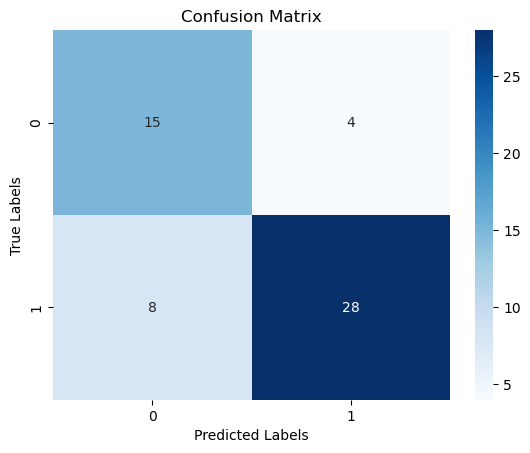

In [65]:
#Draw confusion heatmap
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

cm = confusion_matrix(transformed_tweets_sentiment_2['Survey_Results'], transformed_tweets_sentiment_2['Model_Results'])
ax = plt.subplot()
sns.heatmap(cm, annot=True, ax = ax, cmap='Blues', fmt="d")

#Title and labels
ax.set_title('Confusion Matrix')
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')



In [64]:
#Show TP, TN, FP, FN
print('True Positive: ', cm[0][0])
print('True Negative: ', cm[1][1])
print('False Positive: ', cm[1][0])
print('False Negative: ', cm[0][1])

True Positive:  15
True Negative:  28
False Positive:  8
False Negative:  4


In [62]:
#calculate the accuracy of the model
from sklearn.metrics import accuracy_score
accuracy_score(transformed_tweets_sentiment_2['Survey_Results'], transformed_tweets_sentiment_2['Model_Results'])


0.7818181818181819

In [22]:
#Check for sentiment in the all_tweets_edited dataset using the tweetnlp library and save the results in a new column called sentiment
model = tweetnlp.load_model('sentiment')
#Create a new dataframe called transformed_tweets_sentiment as a copy of all_tweets_edited
transformed_tweets_sentiment = survey_edited.copy()
transformed_tweets_sentiment['sentiment'] = transformed_tweets_sentiment['text'].apply(lambda x: model.predict(x)['label'])

# Filter out rows that contaion "negative" in the sentiment column
transformed_tweets_sentiment = transformed_tweets_sentiment[~transformed_tweets_sentiment['sentiment'].str.contains("negative")]
number_total_tweets = len(transformed_tweets_sentiment)

#Printing tweet length after filtering out the rows that contain "negative" in the sentiment column
print("Number of total tweets after filtering out the rows that contain 'negative' in the sentiment column: ", number_total_tweets)

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Number of total tweets after filtering out the rows that contain 'negative' in the sentiment column:  39


In [26]:
#Create a column and write True if the sentiment is negative and False if the sentiment is positive or neutral
transformed_tweets_sentiment['Model_Results'] = np.where(transformed_tweets_sentiment['sentiment'].isin(['negative']), False, True)
transformed_tweets_sentiment.head(1)

,text,Complaint number,non complaint number,uncertain number,Cem,ecem,Shinu J,Akshay,Erjon,pattern,Survey_Results,sentiment,Model_Results
0,@TLRailUK why don't the doors open at every st...,5,0,0,Doors,Doors,Doors,Door,doors,500,True,neutral,True
